# Indeed.com - Job Description Analyis
I will use NLP (natural language processing) to analyse job adverts scraped from the uk.Indeed.com jobs website

I will focus on UK based jobs in the data industry, mainly in Scottish companies to start with, keeping the data gathering steps manageable, possibly expanding the study to the rest of the UK later.

I will write my own web scraper using the Requests and BeautifulSoup libraries.  I plan to process the text data using the nltk library

## Motivation
Suppose I am running a hypothetical data analytics company.  I have been approached by another company who are hoping to build and recruit a data analytics team.  Since they don't have an existing data analytics team, I have been given a list of skills and experience they think they need.  My challenge is to classify what job title they should be marketing their vacancy for.  Should it be a Data Scientist, or a Data Engineer etc.

I am also (hypothetically) working with candidates to best tailor their CV, project portfolio etc to optimise for the things that data industry recruiters are looking for.  My study should be able to generate a list of the key things for each of the major data professions.

## Sections (rough outline)
- Scrape the data
- Data cleaning
- Data exploration
  - Extracting the list of top skills requirements for each of the main disciplines
  - Picking out common phrases to reference in an optimised CV
- Feature engineering
  - Job description length
  - Years of experience mentioned
  - Salary range (if enough data available)
  - Key tech stack tools included, cloud platforms, databases, NLP, dashboards etc.
  - Mentioning remote, flexible working etc
- Model Building
  - Classifier for labelling a job ad, with the most approproate job title.
  - Na   svieve Bayes
- Model Tuning



In [68]:
# Run this cell always
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import pprint as pp
import os
import indeed.IndeedScraper as ind
from wordcloud import WordCloud

f_name = 'data/data.csv'

# Scrape the data

In [69]:
# Manually trigger running the scraper or just loading existing data
scrape_new = False

if scrape_new or not os.path.isfile(f_name):
    ind.batch_scrape([('Data Scientist', 'Scotland'),
                      ('Data Engineer', 'Scotland'),
                      ('Data Analyst', 'Scotland'),
                      ('Business Analyst', 'Scotland'),
                      ('Machine Learning Engineer', 'Scotland'),
                      ('Machine Learning', 'Scotland'),
                      ('Artificial Intelligence', 'Scotland'),
                      ('AI', 'Scotland'),
                      ('Data', 'Scotland')],
                     pages=20,
                     delay=5,
                     append=False)
    df = pd.read_csv(f_name, index_col=0)
else:
    df = pd.read_csv(f_name, index_col=0)
    print(f'Data read from .csv ({len(df)} rows, {len(df.columns)} columns)')

Data read from .csv (2991 rows, 13 columns)


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 0 to 2990
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2991 non-null   object
 1   id                2991 non-null   object
 2   company           2991 non-null   object
 3   url               2991 non-null   object
 4   location          2991 non-null   object
 5   summary           2991 non-null   object
 6   date              2991 non-null   object
 7   description       2991 non-null   object
 8   description_html  2991 non-null   object
 9   page_format       2991 non-null   int64 
 10  salary            877 non-null    object
 11  query_title       2991 non-null   object
 12  query_loc         2991 non-null   object
dtypes: int64(1), object(12)
memory usage: 327.1+ KB


# Data cleaning

## Drop duplicates
Some (not all) duplicates are removed by the scraping routine.

Check if there are any duplicates in the "id" column.  Since the scraped csv data was simply multiple search queries, then results appended into one big csv file.  It's possible for there to be some duplicates where id numbers are the same, between the multiple batches.

In [71]:
count = df.duplicated('id').sum()
print(f'Number of duplicate rows: {count}')

Number of duplicate rows: 569


In [72]:
print(f'Number of rows before dropping duplicates: {len(df)}')
df = df.drop_duplicates('id', ignore_index=True)
print(f'Number of rows after dropping duplicates:  {len(df)}')

Number of rows before dropping duplicates: 2991
Number of rows after dropping duplicates:  2422


## Fix column dtypes

In [73]:
# Turn query_title into categorical column
df.loc[:,'query_title'] = df['query_title'].astype('category')

## Lowercase

In [74]:
# Switch text columns to lowercase
df.loc[:,'title'] = df['title'].str.lower()
df.loc[:,'description'] = df['description'].str.lower()

## Clean up job titles
Looks like some of the job titles were prefixed with "new...".  This will interfere with the word matching

In [75]:
# Show first 5 rows beginning with "new" prefix
mask = df.title.str.contains('^new', regex=True)
df.loc[mask,'title'].iloc[:5].tolist()

['newdata science lecturer (international development)',
 'newanalytics coordinator',
 'newreporting analyst',
 'newpolicy analyst',
 'newwind analyst']

In [76]:
# Drop the "new" prefix
df.loc[:,'title'] = df.title.agg(lambda x: re.sub('^new','',x,1))

# Check that none with prefix still exist
mask = df.title.str.contains('^new', regex=True)
count = len(df[mask].title.iloc[:10].tolist())
print(f'Number of rows with "new" prefix: {count}')

Number of rows with "new" prefix: 0


# Location data

Came across the library `geopy`.  Could use this to engineer some additional lat/lon features for plotting on a map.  Unless tableau already allows place names.

Geopy uses OSM nominatim service with delay between requests

Might use https://pypi.org/project/postcodes-io-api/ also

In [77]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="jobs-analysis")
# location = geolocator.geocode("175 5th Avenue NYC")

## Combine these into a preprocessing function

In [78]:
# Clean up dataframe
def pre_processing_basic(df):
    '''Pre process the dataframe in a basic way'''
    
    # Drop duplicates
    df = df.drop_duplicates('id', ignore_index=True)
    
    # Fix column types
    df.loc[:,'query_title'] = df['query_title'].astype('category')
    
    # Lower case
    df.loc[:,'title'] = df['title'].str.lower()
    df.loc[:,'description'] = df['description'].str.lower()
    
    # Remove "new..." prefix from some job titles
    df.loc[:,'title'] = df.title.agg(lambda x: re.sub('^new','',x,1))    
    
    return df

# Load the data fresh and run the preprocessor
df = pd.read_csv(f_name, index_col=0)
print(f'BEFORE:{df.shape}')
df_preprocessed = pre_processing_basic(df.copy())
print(f'AFTER: {df_preprocessed.shape}')

BEFORE:(2991, 13)
AFTER: (2422, 13)


C:\Users\adin7\.conda\envs\jobs-analysis\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Feature Engineering

## Detect simple keywords/phrases
Based on intuition about the job types. There should be some key skills, programming languages, tools etc that are specific to each job. So if I can categorise each job with some of these, then there is a chance of training an ML model to classify the jobs using them.

In [79]:
def add_single_skill(df, skill, col, verbose=False):
    '''Generalised function to detect keyword/phrases
    Adds a new column with value == True if the regex pattern is matched'''
    
    df.loc[:,col] = False
    for i, row in df.iterrows():
        doc = row.description
        match = re.search(f'{skill}',doc)
        
        if match is not None:
            numchars = 20
            start = (match.start() - numchars) if (match.start() >= numchars) else 0
            end = (match.end() + numchars) if (match.end() <= len(doc)) else len(doc)
            context = doc[start:end]
            if verbose: print(fr'Found:[{col} @ {i:<3}]  ...{context}...')
            df.loc[i, col] = True
            
    if verbose: print(f'Jobs tagged with {col}: {df.loc[:, col].sum()}')
    return df

In [80]:
# Use this function to generate a load of columns for each keyword/phrase
def add_all_skills(df, verbose=False):
    df = add_single_skill(df, 'python', 'is_python', verbose=verbose);
    df = add_single_skill(df, '\sr(\s|[.,]\s)', 'is_r', verbose=verbose);
    df = add_single_skill(df, 'spark', 'is_spark', verbose=verbose);
    df = add_single_skill(df, 'java[\s,.]', 'is_java', verbose=verbose);
    df = add_single_skill(df, 'javascript', 'is_javascript', verbose=verbose);
    df = add_single_skill(df, 'hadoop', 'is_hadoop', verbose=verbose);
    df = add_single_skill(df, '[\s\(]aws|amazon web', 'is_aws', verbose=verbose);
    df = add_single_skill(df, '[\s\(]gcp|google cloud', 'is_gcp', verbose=verbose);
    df = add_single_skill(df, 'azure', 'is_azure', verbose=verbose);
    df = add_single_skill(df, 'nosql', 'is_nosql', verbose=verbose);
    df = add_single_skill(df, '[^o]sql', 'is_sql', verbose=verbose);
    df = add_single_skill(df, 'mongodb', 'is_mongodb', verbose=verbose);
    df = add_single_skill(df, 'kubernetes', 'is_kubernetes', verbose=verbose);
    df = add_single_skill(df, 'kafka', 'is_kafka', verbose=verbose);
    df = add_single_skill(df, 'hive', 'is_hive', verbose=verbose);
    df = add_single_skill(df, 'nlp|natural language', 'is_nlp', verbose=verbose);
    df = add_single_skill(df, 'tensorflow', 'is_tensorflow', verbose=verbose);
    df = add_single_skill(df, 'keras', 'is_keras', verbose=verbose);
    df = add_single_skill(df, 'pytorch', 'is_pytorch', verbose=verbose);
    df = add_single_skill(df, 'sklearn|sci-?kit-?learn', 'is_sklearn', verbose=verbose);
    df = add_single_skill(df, 'deep learning', 'is_dl', verbose=verbose);
    df = add_single_skill(df, 'etl|extract[,-]? ?transform[,-]? ?load', 'is_etl', verbose=verbose);
    df = add_single_skill(df, 'excel', 'is_excel', verbose=verbose);
    df = add_single_skill(df, 'ml', 'is_ml', verbose=verbose);
    df = add_single_skill(df, 'a\.i\.|[\s\(]ai(\s|[.,]\s)|artificial intelligence', 'is_ai', verbose=verbose);
    df = add_single_skill(df, 'statistics|stats', 'is_stats', verbose=verbose);
    df = add_single_skill(df, 'data[- ]?mining', 'is_data_mining', verbose=verbose);
    df = add_single_skill(df, 'data[- ]?analysis|data[- ]?analytics', 'is_data_analytics', verbose=verbose);
    df = add_single_skill(df, 'big[ -]?data', 'is_big_data', verbose=verbose);
    df = add_single_skill(df, 'computer vision|machine vision', 'is_com_vision', verbose=verbose);
    df = add_single_skill(df, 'c\+\+', 'is_c_plus_plus', verbose=verbose);
    df = add_single_skill(df, '\ssas(\s|[.,]\s)', 'is_sas', verbose=verbose);
    df = add_single_skill(df, 'matlab', 'is_matlab', verbose=verbose);
    df = add_single_skill(df, 'tableau', 'is_tableau', verbose=verbose);
    df = add_single_skill(df, 'power[- ]?bi', 'is_power_bi', verbose=verbose);
    df = add_single_skill(df, 'prediction|predictive', 'is_predictive', verbose=verbose);
    df = add_single_skill(df, 'story[- ]?telling| story ', 'is_story', verbose=verbose);
    df = add_single_skill(df, 'presentation|presenting|present', 'is_presenting', verbose=verbose);
    df = add_single_skill(df, 'trader|trading', 'is_trading', verbose=verbose);
    df = add_single_skill(df, 'jupyter', 'is_jupyter', verbose=verbose);
    df = add_single_skill(df, 'airflow', 'is_airflow', verbose=verbose);
    df = add_single_skill(df, 'databricks', 'is_databricks', verbose=verbose);
    df = add_single_skill(df, 'cloud', 'is_cloud', verbose=verbose);
    df = add_single_skill(df, 'dev[-]?ops', 'is_devops', verbose=verbose);
    
    return df

In [81]:
df_preprocessed = add_all_skills(df_preprocessed, verbose=False)

## Extract the target variable "job title"
Note this method of setting the target variable depends on the roles being accurately described already.  Might be an action for the future, that I could scrape the wikipedia etc page for each job title, and match up with skills etc according to that.

In [82]:
def add_target_variable(df):
    count_unmatched = 0
    for index, row in df.iterrows():
        title = row.title
        title_simplified = 'Data Scientist' if 'data scientist' in title else '-'

        if re.match('.*data.*scien(tist|ce).*', title) is not None:
            title_simplified = 'data scientist'
        elif 'nlp' in title:
            title_simplified = 'nlp'
        elif 'data analyst' in title:
            title_simplified = 'data analyst'
        elif re.match('.*data.*analy(st|tics).*', title) is not None:
            title_simplified = 'data analyst'
        elif 'data engineer' in title or 'cloud engineer' in title:
            title_simplified = 'data engineer'
        elif 'business analyst' in title:
            title_simplified = 'business analyst'
        elif re.match('.*(business.*(intel|analy(sis|st))|bi).*', title) is not None:
            title_simplified = 'business intelligence'
        elif re.match('.*machine.*learning.*', title) is not None:
            title_simplified = 'machine learning engineer'
        elif re.match('.*(artificial.*intelligence|\sai\s).*', title) is not None:
            title_simplified = 'ai'
        elif re.match('.*software.*engineer.*', title) is not None:
            title_simplified = 'software engineer'
        elif re.match('.*analy(st|tics).*', title) is not None:
            title_simplified = 'analyst'
        elif 'systems' in title:
            title_simplified = 'systems'
        elif 'software develop' in title:
            title_simplified = 'software developer'
        elif 'developer' in title:
            title_simplified = 'developer'
        elif 'research' in title:
            title_simplified = 'research'
        elif 'scientist' in title:
            title_simplified = 'scientist'
        elif 'admin' in title:
            title_simplified = 'admin'
        elif 'devops' in title:
            title_simplified = 'devops'
        else:
            title_simplified = 'other'
#             print(f'Extracted: Query:"{row.query_title}" Title:"{title}"')
            count_unmatched = count_unmatched + 1
            
        df.loc[index, 'title_simplified'] = title_simplified

    print(f'Count of unmatched: {count_unmatched}')
    print(f'Cound of matched:   {len(df)-count_unmatched} ')
    return df

df_preprocessed = add_target_variable(df_preprocessed)

Count of unmatched: 656
Cound of matched:   1766 


In [83]:
# Print list of simplified job titles and their counts
value_counts = df_preprocessed.title_simplified.value_counts()
value_counts

other                        656
data scientist               306
data analyst                 300
business analyst             293
analyst                      179
machine learning engineer    143
business intelligence        143
research                      72
software engineer             67
admin                         54
developer                     52
data engineer                 47
ai                            41
systems                       21
software developer            18
scientist                     18
devops                         7
nlp                            5
Name: title_simplified, dtype: int64

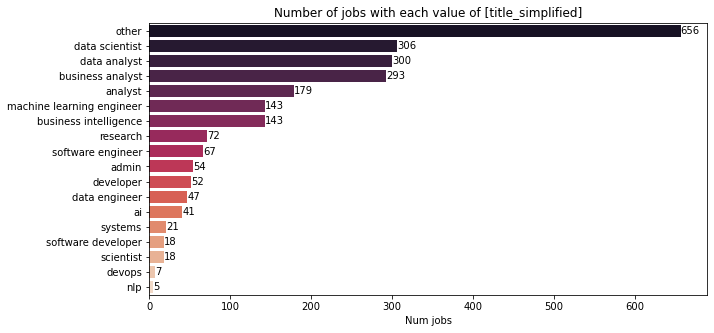

In [84]:
# Plot a bar chart

# Code snippet from Stackoverflow to print values onto plot - https://stackoverflow.com/a/56780852
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() *  3/4
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

fig = plt.figure()
fig.set_size_inches(10,5)
ax = sns.barplot(y=value_counts.index, x=value_counts.values, palette='rocket');
ax.set_title('Number of jobs with each value of [title_simplified]');
ax.set_xlabel('Num jobs');
show_values_on_bars(ax, "h", 0.3)

- Most common class in the dataset is "other".  I may undersample this class, or oversample the others if I think class imbalance is influencing the results.
- There are lots of `analyst` jobs that aren't `data analyst` or `business analyst`.
- Some job titles had very few mentions.  They aren't going to be a big enough category of their own so I should combine into another category, for example.
  - `nlp` and `ai` combine with `data scientist`
  - `systems` and `devops` combine with `software engineer`

In [85]:
# Aggregate nlp and ai jobs to data scientist
mask = df_preprocessed['title_simplified'].isin(['nlp','ai'])
print(f'Number of "nlp" and "ai" jobs BEFORE: {mask.sum()}')

df_preprocessed.loc[mask,'title_simplified'] = 'data scientist'
mask = df_preprocessed['title_simplified'].isin(['nlp','ai'])
print(f'Number of "nlp" and "ai" jobs AFTER: {mask.sum()}')

Number of "nlp" and "ai" jobs BEFORE: 46
Number of "nlp" and "ai" jobs AFTER: 0


In [86]:
# Aggregate systems and devops jobs to software engineer
mask = df_preprocessed['title_simplified'].isin(['systems','devops'])
print(f'Number of "systems" and "devops" jobs BEFORE: {mask.sum()}')

df_preprocessed.loc[mask,'title_simplified'] = 'software engineer'
mask = df_preprocessed['title_simplified'].isin(['systems','devops'])
print(f'Number of "systems" and "devops" jobs AFTER: {mask.sum()}')

Number of "systems" and "devops" jobs BEFORE: 28
Number of "systems" and "devops" jobs AFTER: 0


In [87]:
# Save a copy of df after preprocessing
df_preprocessed.to_csv('df_preprocessed.csv')

In [27]:
# Function to print the top skills appearing in a given category
def get_top_skills(df, title, n, verbose=False):
    df = df[df.title_simplified == title]
    skills_freq = dict()
    
    skills = [x for x in df.columns.tolist() if 'is_' in x]
    for skill in skills:
        skills_freq[skill] = df[skill].sum()
        
    skills_sorted = sorted(skills_freq.items(), key=lambda x: x[1], reverse=True)

    # skills_top, counts_top = zip(*skills_sorted)
    if verbose:
        print(f'Top {n} skills for: "{title}"')
        for s, c in skills_sorted[:n]:
            print(f'Skill: {s:-<30} Freq: {c/len(df)*100:.0f}%')
        print('')
        
    return skills_sorted

In [28]:
n = 5
skills_sorted = get_top_skills(df_preprocessed, 'admin', n, verbose=True)
skills_sorted = get_top_skills(df_preprocessed, 'data scientist', n, verbose=True)
skills_sorted = get_top_skills(df_preprocessed, 'data engineer', n, verbose=True)  
skills_sorted = get_top_skills(df_preprocessed, 'business analyst', n, verbose=True)
skills_sorted = get_top_skills(df_preprocessed, 'machine learning engineer', n, verbose=True)
skills_sorted = get_top_skills(df_preprocessed, 'software engineer', n, verbose=True)

Top 5 skills for: "admin"
Skill: is_excel---------------------- Freq: 78%
Skill: is_presenting----------------- Freq: 11%
Skill: is_sql------------------------ Freq: 9%
Skill: is_ml------------------------- Freq: 9%
Skill: is_etl------------------------ Freq: 7%

Top 5 skills for: "data scientist"
Skill: is_python--------------------- Freq: 72%
Skill: is_sql------------------------ Freq: 48%
Skill: is_excel---------------------- Freq: 43%
Skill: is_stats---------------------- Freq: 39%
Skill: is_ai------------------------- Freq: 38%

Top 5 skills for: "data engineer"
Skill: is_sql------------------------ Freq: 72%
Skill: is_cloud---------------------- Freq: 66%
Skill: is_python--------------------- Freq: 62%
Skill: is_etl------------------------ Freq: 45%
Skill: is_excel---------------------- Freq: 40%

Top 5 skills for: "business analyst"
Skill: is_excel---------------------- Freq: 59%
Skill: is_presenting----------------- Freq: 36%
Skill: is_data_analytics------------- Freq: 13%
Skil

- Clearly, each job title relates to different key skills, so this could be a reasonable predictor for a classifer
- Data scientist jobs are most frequently asking for python, sql and stats experience
  - 72% mentioned python, under 50% mentioned sql and excel/stats
- Data engineers are most frequently asked for sql, cloud and python experience
  - Python, SQL and "cloud" were mentioned in >62% of Data Engineer job ads
- **Surprisingly**, a large number of software engineer jobs also make mention of "ai"

In [29]:
# Compute a Pivot table
cols = [x for x in df_preprocessed.columns.tolist() if 'is_' in x]
piv = df_preprocessed.pivot_table(values=cols, index='title_simplified', aggfunc=np.sum, margins=True)
piv

,is_ai,is_airflow,is_aws,is_azure,is_big_data,is_c_plus_plus,is_cloud,is_com_vision,is_data_analytics,is_data_mining,...,is_r,is_sas,is_sklearn,is_spark,is_sql,is_stats,is_story,is_tableau,is_tensorflow,is_trading
title_simplified,,,,,,,,,,,,,,,,,,,,,
admin,3,0,0,0,2,0,1,0,3,1,...,0,0,0,0,5,0,0,0,0,0
analyst,28,5,7,12,5,0,27,1,71,8,...,13,11,0,3,47,24,9,17,0,9
business analyst,9,0,2,12,4,0,29,1,39,0,...,2,1,0,1,20,6,8,4,0,8
business intelligence,22,5,20,9,19,2,33,0,26,3,...,10,3,0,9,47,5,4,16,0,6
data analyst,24,0,11,8,15,1,28,3,104,9,...,31,7,2,5,106,38,14,50,0,10
data engineer,7,3,17,13,9,5,31,0,6,0,...,8,3,0,13,34,4,1,4,0,0
data scientist,134,4,54,41,71,24,108,27,98,32,...,129,14,27,55,169,139,28,44,36,12
developer,30,1,11,4,5,6,19,1,4,0,...,1,2,0,0,20,2,0,2,1,3
machine learning engineer,67,3,32,11,21,40,37,24,17,9,...,5,0,20,23,24,33,3,3,54,3


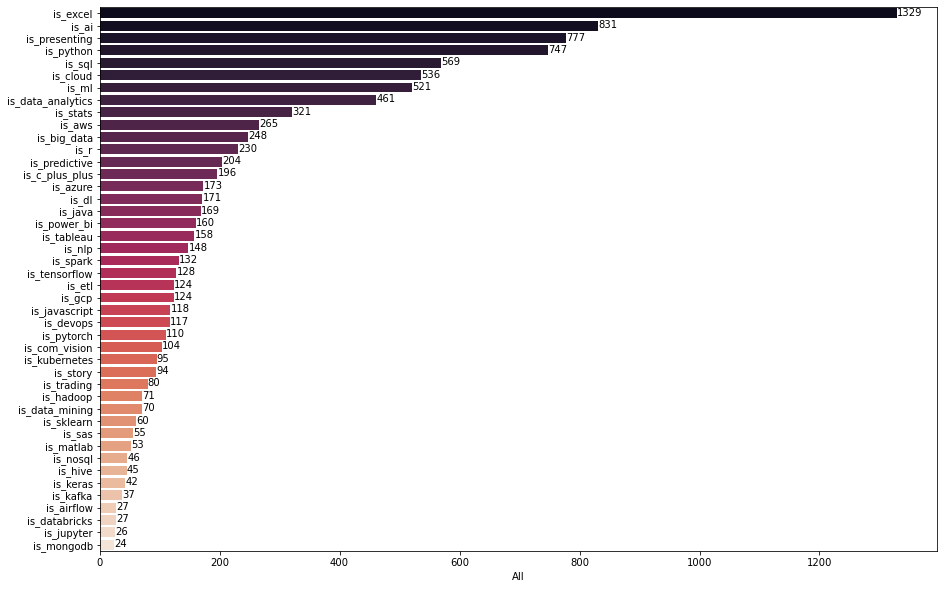

In [30]:
plt.figure(figsize=(15,10))
order = [x for _, x in sorted(zip(piv.loc['All'], piv.columns.tolist()), key=lambda z: z[0], reverse=True)]
ax = sns.barplot(y=piv.columns.tolist(), x=piv.loc['All',:], order=order, palette='rocket');
show_values_on_bars(ax, "h", 0.3)

- Excel is mentioned the most (this will be because it's the most demanded skill in the `others` category and that category is dominant in this dataset)
- `ai` is a buzzword so it shows up often.
- `presenting` is a soft skill that many types of roles seem to require

I am interested in Data Scientist roles, so let's plot the same thing, for the data scientist jobs only

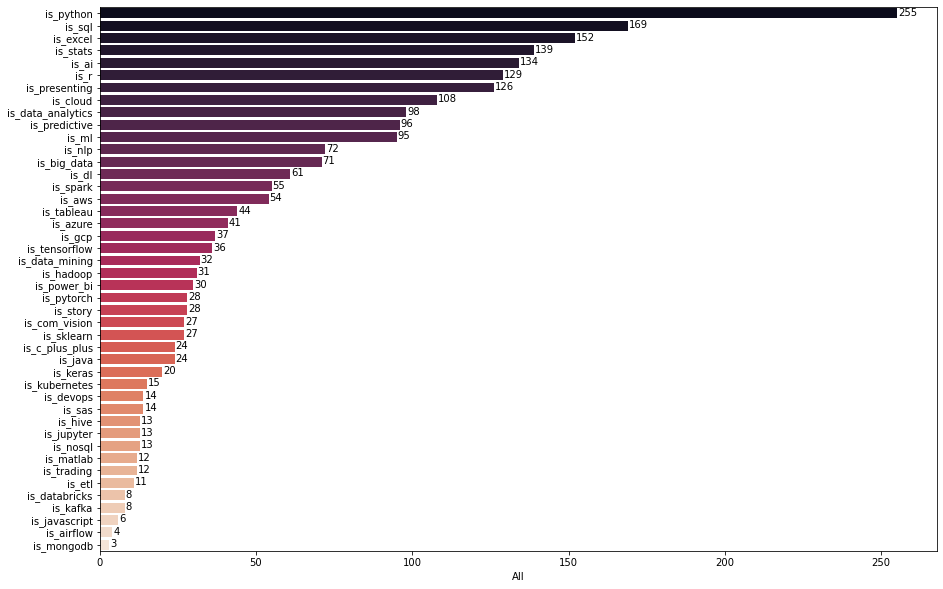

In [31]:
# Compute a Pivot table for data scientist jobs only
mask = df_preprocessed['title_simplified'] == 'data scientist'

piv2 = df_preprocessed[mask].pivot_table(values=cols, index='title_simplified', aggfunc=np.sum, margins=True)

plt.figure(figsize=(15,10))
order = [x for _, x in sorted(zip(piv2.loc['All'], piv2.columns.tolist()), key=lambda z: z[0], reverse=True)]
ax = sns.barplot(y=piv2.columns.tolist(), x=piv2.loc['All',:], order=order, palette='rocket');
show_values_on_bars(ax, "h", 0.3)

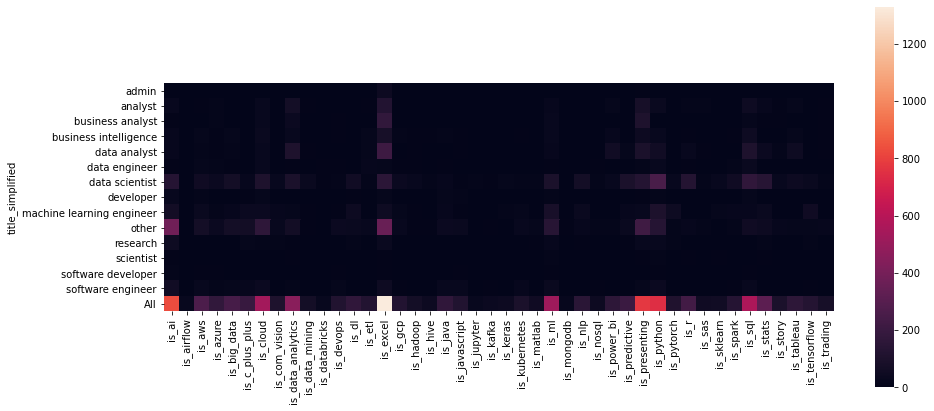

In [32]:
# Plot a heatmap to visually see the most popularly requested skills for each job title.
plt.figure(figsize=(15,7))
sns.heatmap(piv, square=True);

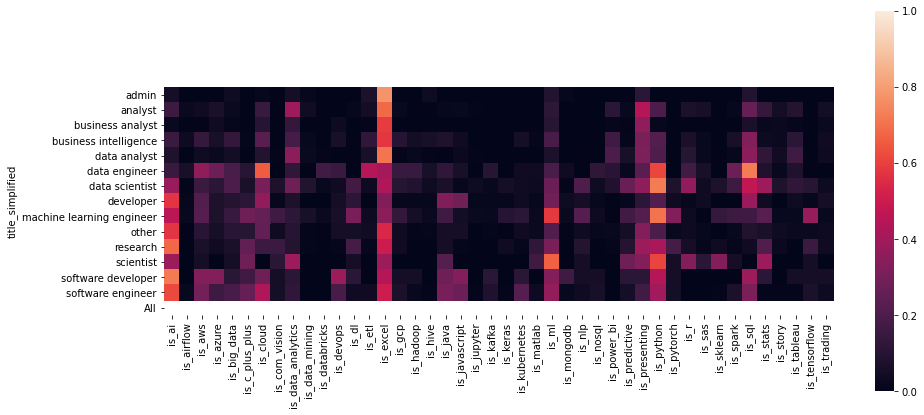

In [33]:
# Class imbalance seems to be throwing off the 
count_per_job = [len(df_preprocessed[df_preprocessed['title_simplified'] == x]) for x in list(piv.index)]
piv_normalised = piv.div(count_per_job, axis='rows')

# Plot a normalised heatmap to visually see the most popularly requested skills for each job title.
plt.figure(figsize=(15,7))
sns.heatmap(piv_normalised, square=True,  cmap='rocket', vmin=0, vmax=1);

This is much easier to interpret.
- Looks like almost all job types require excel experience in high proportions
- Only data engineers require "databricks" experience with any frequency.
- There is no real demand for: airflow, jupyter, 

Ways to further imrove this visualisation:
- Could sort the column ordering according to the total number of job ads for each one.

In [34]:
df_preprocessed.columns.tolist()

['title',
 'id',
 'company',
 'url',
 'location',
 'summary',
 'date',
 'description',
 'description_html',
 'page_format',
 'salary',
 'query_title',
 'query_loc',
 'is_python',
 'is_r',
 'is_spark',
 'is_java',
 'is_javascript',
 'is_hadoop',
 'is_aws',
 'is_gcp',
 'is_azure',
 'is_nosql',
 'is_sql',
 'is_mongodb',
 'is_kubernetes',
 'is_kafka',
 'is_hive',
 'is_nlp',
 'is_tensorflow',
 'is_keras',
 'is_pytorch',
 'is_sklearn',
 'is_dl',
 'is_etl',
 'is_excel',
 'is_ml',
 'is_ai',
 'is_stats',
 'is_data_mining',
 'is_data_analytics',
 'is_big_data',
 'is_com_vision',
 'is_c_plus_plus',
 'is_sas',
 'is_matlab',
 'is_tableau',
 'is_power_bi',
 'is_predictive',
 'is_story',
 'is_presenting',
 'is_trading',
 'is_jupyter',
 'is_airflow',
 'is_databricks',
 'is_cloud',
 'is_devops',
 'title_simplified']

In [35]:
df_preprocessed[df_preprocessed.title_simplified == 'scientist'].title.tolist()

['applied scientist recruiting engine',
 'applied scientist (remote)',
 'senior applied scientist',
 'senior applied scientist (remote)',
 'applied scientist (remote)',
 'applied scientist',
 'senior applied scientist - video advertising',
 'senior applied scientist (remote)',
 'applied scientist (remote)',
 'applied scientist - threat reduction',
 'senior algorithm engineer; scientist; physics, mat',
 'application scientist',
 'visiting scientist, ai',
 'associate imaging scientist',
 'membrane protein scientist',
 'scientists, engineers technologists and leaders for cyber an...',
 'ai scientist - computer vision',
 'ai scientist - natural language processing']

# Build a classification model

## Reload the data fresh and run preprocessor funcs

In [36]:
df = pd.read_csv(f_name, index_col=0)
print(f'Data read from .csv\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = pre_processing_basic(df)
print(f'Preprocessing complete\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = add_all_skills(df, verbose=False)
print(f'Skills extracted as feature columns\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = add_target_variable(df)
print(f'Target variable added\n>> ({len(df.title_simplified.unique())} unique job titles)')

Data read from .csv
>> (2991 rows, 13 columns)

Preprocessing complete
>> (2422 rows, 13 columns)



C:\Users\adin7\.conda\envs\jobs-analysis\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Skills extracted as feature columns
>> (2422 rows, 57 columns)

Count of unmatched: 656
Cound of matched:   1766 
Target variable added
>> (18 unique job titles)


## Split training and testing data

In [37]:
# Drop everything but Data Analyst, Data Scientist, Data Engineer, Business Analyst
df = df.drop(df[~df.title_simplified.isin(['data scientist', 
                                           'data analyst', 
                                           'data engineer', 
                                           'business analyst'])].index)
print(f'Dropped rows outside of selection\n>> ({len(df)} rows, {len(df.columns)} columns remaining)')

Dropped rows outside of selection
>> (946 rows, 58 columns remaining)


In [38]:
from sklearn.model_selection import train_test_split

# Assign X, y
y = df.title_simplified
X = df[['is_python', 'is_r', 'is_spark', 'is_java',
       'is_javascript', 'is_hadoop', 'is_aws', 'is_gcp', 'is_azure',
       'is_nosql', 'is_sql', 'is_mongodb', 'is_kubernetes', 'is_kafka',
       'is_hive', 'is_nlp', 'is_tensorflow', 'is_keras', 'is_pytorch',
       'is_sklearn', 'is_dl', 'is_etl', 'is_excel', 'is_ml', 'is_ai',
       'is_stats', 'is_data_mining', 'is_data_analytics', 'is_big_data',
       'is_com_vision', 'is_c_plus_plus', 'is_sas', 'is_matlab', 'is_tableau',
       'is_power_bi', 'is_predictive', 'is_story', 'is_presenting',
       'is_trading', 'is_jupyter', 'is_airflow', 'is_databricks', 'is_cloud',
       'is_devops']]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a dummy classifier

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score 
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [40]:
# Train a dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_train)
dummy_score = accuracy_score(y_train,y_pred)
print(f'Dummy/null accuracy: {dummy_score:.3f}')

Dummy/null accuracy: 0.324


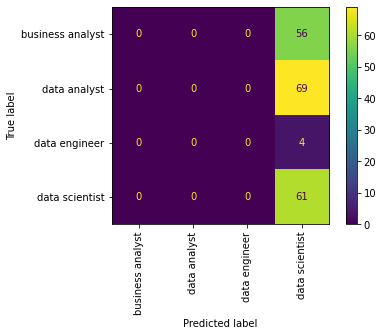

In [41]:
plot_confusion_matrix(dummy_clf, X_test, y_test, values_format='d', xticks_rotation='vertical');

Dummy classifier always predicted "data scientist" (must be most frequent label in this dataset).

In [42]:
y_train.value_counts()

data scientist      245
business analyst    237
data analyst        231
data engineer        43
Name: title_simplified, dtype: int64

**data engineer** is underrepresented in this data.  We don't want the model to just learn the distributions, but to actually discern relationships between the individual labels.

## Addressing data imbalance

In [43]:
# from sklearn.utils import resample
# X, y = resample(X, y, random_state=0)

Oversampling the under-represented classes using SMOTE from imbalanced-learn package

Followed along with: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

**NOTE:** Recommended *NOT* to resample the testing data, only the training set.

In [44]:
# Oversampling using SMOTE
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

data engineer       245
business analyst    245
data scientist      245
data analyst        245
Name: title_simplified, dtype: int64

Looks like all classes are now represented equally in the training set

## Naive Bayes classifier from sklearn

In [45]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()

In [46]:
clf_nb.fit(X_train, y_train);

In [47]:
# Check accuracy metric
accuracy_score(y_test, clf_nb.predict(X_test))

0.6052631578947368

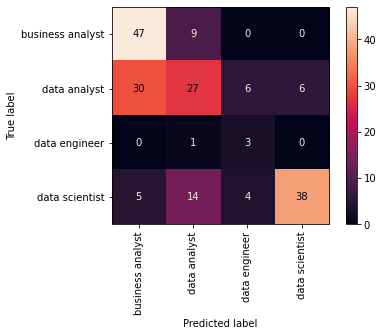

In [48]:
plot_confusion_matrix(clf_nb, X_test, y_test, values_format='d', xticks_rotation='vertical', cmap='rocket');

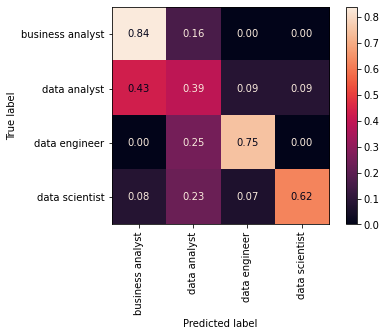

In [49]:
# Re-plot the matrix with normalisation by the occurrances of the true classes (rows). (hides the class imbalance)
plot_confusion_matrix(clf_nb, X_test, y_test, values_format='.2f', xticks_rotation='vertical', normalize='true', cmap='rocket');

**Summary:** 
- On first pass, the naive bayes was able to achieve 60% accuracy. Not terrible!
- Seems to have issue distinguishing between `data analyst` and `business analyst` probably not surprising since relatively similar jobs.
- Frequently `data analysts` are  mis-classified as business analysts, but not often the other way round
- `data scientists` classified reasonably well.  Most often mis-classified as data analyst, not surprising again.
- `data engineers` classified well, but low occurrance in testing set, 
- business analysts were often classified accurately.
- Test data is imbalanced, but this doesn't matter much since it's meant to accurately represent real world distributions

# Try a decision tree

In [50]:
clf_tree = DecisionTreeClassifier(max_depth=3)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [51]:
accuracy_score(y_test, clf_tree.predict(X_test))

0.5526315789473685

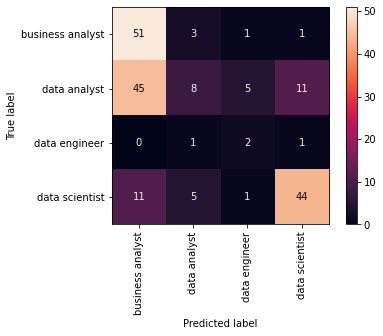

In [52]:
plot_confusion_matrix(clf_tree, X_test, y_test, values_format='d', xticks_rotation='vertical', cmap='rocket')

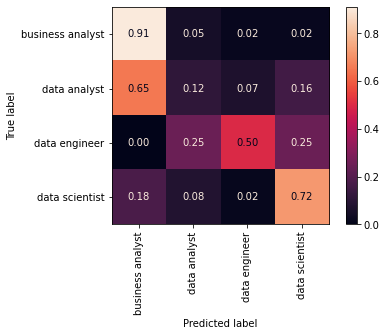

In [53]:
# Normalised confusion matrix
plot_confusion_matrix(clf_tree, X_test, y_test, values_format='.2f', xticks_rotation='vertical', normalize='true', cmap='rocket')

Decision tree making errors on data engineers, data analysts but OK on other classes

[Text(418.5, 475.65000000000003, 'X[0] <= 0.5\ngini = 0.75\nsamples = 980\nvalue = [245, 245, 245, 245]'),
 Text(209.25, 339.75, 'X[21] <= 0.5\ngini = 0.682\nsamples = 578\nvalue = [242, 192, 88, 56]'),
 Text(104.625, 203.85000000000002, 'X[10] <= 0.5\ngini = 0.622\nsamples = 495\nvalue = [240, 178, 23, 54]'),
 Text(52.3125, 67.94999999999999, 'gini = 0.574\nsamples = 409\nvalue = [227, 133, 3, 46]'),
 Text(156.9375, 67.94999999999999, 'gini = 0.641\nsamples = 86\nvalue = [13, 45, 20, 8]'),
 Text(313.875, 203.85000000000002, 'X[24] <= 0.5\ngini = 0.357\nsamples = 83\nvalue = [2, 14, 65, 2]'),
 Text(261.5625, 67.94999999999999, 'gini = 0.288\nsamples = 78\nvalue = [1, 10, 65, 2]'),
 Text(366.1875, 67.94999999999999, 'gini = 0.32\nsamples = 5\nvalue = [1, 4, 0, 0]'),
 Text(627.75, 339.75, 'X[21] <= 0.5\ngini = 0.609\nsamples = 402\nvalue = [3, 53, 157, 189]'),
 Text(523.125, 203.85000000000002, 'X[25] <= 0.5\ngini = 0.578\nsamples = 317\nvalue = [3, 50, 82, 182]'),
 Text(470.8125, 67.949

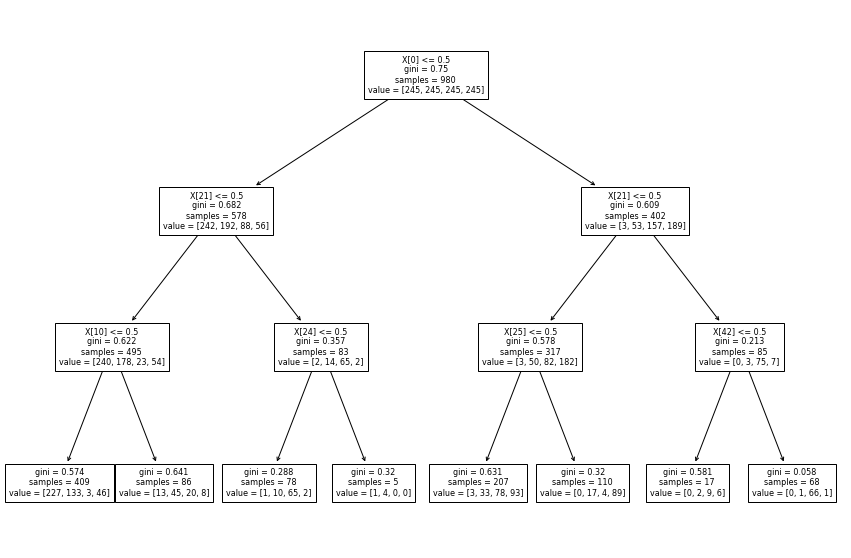

In [54]:
# Visualise the tree
from sklearn.tree import plot_tree

fig, ax = plt.subplots()
fig.set_size_inches(15,10)
plot_tree(clf_tree, fontsize=8)

In [55]:
## Try a quick gridsearch to see if decision tree is better with some tuning
param_grid = {'max_depth': [3,10,30,100],
             'min_samples_leaf': [1,3]}
tune_tree = GridSearchCV(clf_tree, param_grid, scoring='accuracy', verbose=0)

tune_tree.fit(X_train, y_train);
clf_tree_tune = tune_tree.best_estimator_
clf_tree_tune

DecisionTreeClassifier(max_depth=10)

In [56]:
results = pd.DataFrame(tune_tree.cv_results_)
results[['params','mean_test_score']]

,params,mean_test_score
0,"{'max_depth': 3, 'min_samples_leaf': 1}",0.607143
1,"{'max_depth': 3, 'min_samples_leaf': 3}",0.607143
2,"{'max_depth': 10, 'min_samples_leaf': 1}",0.718367
3,"{'max_depth': 10, 'min_samples_leaf': 3}",0.675510
4,"{'max_depth': 30, 'min_samples_leaf': 1}",0.713265
5,"{'max_depth': 30, 'min_samples_leaf': 3}",0.671429
6,"{'max_depth': 100, 'min_samples_leaf': 1}",0.705102
7,"{'max_depth': 100, 'min_samples_leaf': 3}",0.669388


In [57]:
accuracy_score(y_test, clf_tree_tune.predict(X_test))

0.5842105263157895

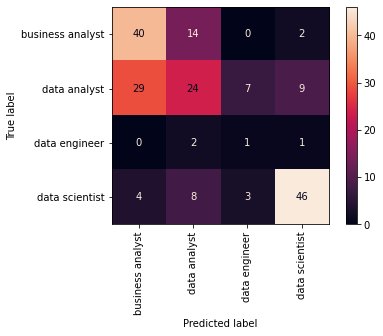

In [58]:
plot_confusion_matrix(clf_tree_tune, X_test, y_test, values_format='d', xticks_rotation='vertical', cmap='rocket')

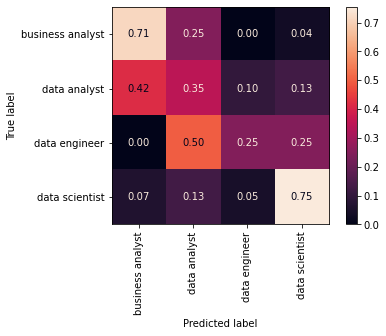

In [59]:
# Normalised confusion matrix
plot_confusion_matrix(clf_tree_tune, X_test, y_test, values_format='.2f', xticks_rotation='vertical', normalize='true', cmap='rocket')

After tuning the accuracy on test set was still quite low.  Maybe gridsearch is not helping with the rebalanced data in this way.

# Use NLTK to build a more automated NLP based pipeline

In [60]:
## Reload the data fresh again
df = pd.read_csv(f_name, index_col=0)
print(f'Data read from .csv\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = pre_processing_basic(df)
print(f'Preprocessing complete\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

# Don't want to add the skills columns, this time we want to use NLP to extract features
# df = add_all_skills(df, verbose=False)
# print(f'Skills extracted as feature columns\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = add_target_variable(df)
print(f'\nTarget variable added\n>> ({len(df.title_simplified.unique())} unique job titles)')

Data read from .csv
>> (2991 rows, 13 columns)

Preprocessing complete
>> (2422 rows, 13 columns)



C:\Users\adin7\.conda\envs\jobs-analysis\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Count of unmatched: 656
Cound of matched:   1766 

Target variable added
>> (18 unique job titles)


## Remove stopwords
First check the most frequent words using nltk.probability.FreqDist

In [61]:
# Develop the NLP feature extraction pipeline using just the first job description only
text = df.description.iloc[0]

In [64]:
from nltk.probability import FreqDist

words = nltk.word_tokenize(text)
fdist = FreqDist(words_stop)

# Print the 10 most frequent words
print([x[0] for x in fdist.most_common(20)])

['and', ',', 'to', 'data', 'you', 'the', 'a', '’', 'of', 'as', 'experience', 'll', 'with', 'in', '.', 'business', 'analysis', 'using', 'science', 'such']


Lots of useless words in that list.  Lets remove all the standard English Stopwords

In [65]:
# Remove all occurrances of English stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
words_stop = [x for x in words if x not in stop_words]

# Print the 10 most frequent again
fdist = FreqDist(words_stop)
print([x[0] for x in fdist.most_common(20)])

[',', 'data', '’', 'experience', '.', 'business', 'analysis', 'using', 'science', 'methods', "'ll", 'work', 'including', 'also', 'development', 'building', 'techniques', 'need', 'based', 'models']


This looks like it still includes punctuation, remove these entries to get a clearer picture of the top words in the dataset.  Both punctuation and stopwords in one step

In [66]:
words = [x for x in words if (x not in stop_words) & (x.isalpha())]
fdist = FreqDist(words)
print([x[0] for x in fdist.most_common(20)])

['data', 'experience', 'business', 'analysis', 'using', 'science', 'methods', 'work', 'including', 'also', 'development', 'building', 'techniques', 'need', 'based', 'models', 'us', 'scientist', 'identifying', 'problems']


In [101]:
def pre_processing_nltk(document):
    '''Pre process a single job description using nltk'''
    
    # Split into paragraphs using \n
    paragraphs = document.split('\n')
    
    # Tokenise each para into sentences, giving a list of sentences
    sentences = []
    for para in paragraphs:
        sentences.extend(nltk.sent_tokenize(para))   # Using Extend instead of Append
        
    # Tokenize each sentence to get a list of lists of words
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words("english"))
    sentences_filt = []
    for sent in sentences:
        sent = [w for w in sent if (w not in stop_words) & (w.isalpha())]
        sentences_filt.append(sent)
        
    return sentences_filt
    
# Test that the tokenization result on a one-off job
document = df.description.iloc[1]
print(f'BEFORE:"{document[:350]}..."\n')
sentences = pre_processing_nltk(document)
print(f'AFTER: {sentences[0:2]}...')

BEFORE:"My client supports international organisations in the pharmaceutical and healthcare industries across a range of bespoke projects. They maximise data utility to allow for innovation, efficiency, and developments in healthcare.Culturally, the business has an extensive pool of expertise and is an excellent place to develop your career. The business o..."

AFTER: [['My', 'client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke', 'projects'], ['They', 'maximise', 'data', 'utility', 'allow', 'innovation', 'efficiency', 'developments', 'business', 'extensive', 'pool', 'expertise', 'excellent', 'place', 'develop', 'career']]...


In [99]:
# Remove stopwords and punctuation
def remove_stopwords(sentences):
    # load stopwords and
    stop_words = set(stopwords.words("english"))
    sentences_filt = []
    for sent in sentences:
        sent = [w for w in sent if (w not in stop_words) & (w.isalpha())]
        sentences_filt.append(sent)
    return sentences_filt
            
# Test the function works a expected
print(f'BEFORE: {sentences[0]}...\n')
sentences_filt = remove_stopwords(sentences)
print(f'AFTER:  {sentences_filt[0]}...')

BEFORE: ['My', 'client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke', 'projects']...

AFTER:  ['My', 'client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke', 'projects']...


## Apply preprocessing to full df of jobs
Will need to iterate through each row in the df, applying the tokeniser

In [109]:
# Remove stopwords and punctuation
def remove_stopwords_doc(doc):
    # load stopwords and
    stop_words = set(stopwords.words("english"))
    words = [w for w in doc if (w not in stop_words) & (w.isalpha())]
    return words
            
# Test the function works a expected
print(f'BEFORE: {sentences[0]}...\n')
sentences_filt = remove_stopwords(sentences)
print(f'AFTER:  {sentences_filt[0]}...')

# def remove_stopwords_sents(sents):
#     # load stopwords and
#     stop_words = set(stopwords.words("english"))
#     words = [w for sent in sents for w in sent if (w not in stop_words) & (w.isalpha())]
#     return words

BEFORE: ['My', 'client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke', 'projects']...

AFTER:  ['My', 'client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke', 'projects']...


In [190]:

# REWRITE
def pre_process(df, verbose=False):
    sent_f_list = []
    for index, row in df.iterrows():
        document = row.description.lower()
        document = document.replace('\n',' ')
        words = nltk.word_tokenize(document)
        words_f = remove_stopwords_doc(words)
        if verbose: print(f'BEFORE:   "{document[:80]}..."')
        # if verbose: print(f'RM_STOPWORDS: {words_f[:10]}...')
        if verbose: print(f'Number of WORDS: {len(words_f)}')
        
        # Do the same but on a per-sentence basis.
        # Might eventually put n-grams in this loop.
        sents = nltk.sent_tokenize(document)
        sents = [remove_stopwords_doc(nltk.word_tokenize(sent)) for sent in sents]
        sent_f = []
        for sent in sents:
            sent_f.append(remove_stopwords_doc(sent))
        sent_f = [sent for sents in sent_f for sent in sents]
        word_set = set(sent_f)
        if verbose: print(f'BY SENT: {sent_f[:10]}...')
        if verbose: print(f'Number of SENTENCES: {len(sents)}')       
        if verbose: print(f'Number of UNIQUE WORDS: {len(word_set)}\n')
        sent_f_list.append(sent_f)
                        
    return sent_f_list

sent_list = pre_process(df.head(3), verbose=True)
# sent_list


BEFORE:   "join us as a data scientist you’ll be identifying and working with large, comple..."
Number of WORDS: 318
BY SENT: ['join', 'us', 'data', 'scientist', 'identifying', 'working', 'large', 'complex', 'data', 'sets']...
Number of SENTENCES: 8
Number of UNIQUE WORDS: 222

BEFORE:   "my client supports international organisations in the pharmaceutical and healthc..."
Number of WORDS: 123
BY SENT: ['client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke']...
Number of SENTENCES: 4
Number of UNIQUE WORDS: 112

BEFORE:   "job overview a product led healthtech start up the is utilizing ai and ml to del..."
Number of WORDS: 116
BY SENT: ['job', 'overview', 'product', 'led', 'healthtech', 'start', 'utilizing', 'ai', 'ml', 'deliver']...
Number of SENTENCES: 9
Number of UNIQUE WORDS: 81



In [194]:

from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc
count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
X = count_vect.fit_transform(sent_list)
X

def pre_process_counts(df, verbose=False):
    sent_list = pre_process(df, verbose=verbose)
    count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
    X = count_vect.fit_transform(sent_list)
    return X

## Use above to train model
Use above tokenizer and count vectorisor to train a new model using just text data

In [191]:
df = pd.read_csv(f_name, index_col=0)
print(f'Data read from .csv\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = pre_processing_basic(df)
print(f'Preprocessing complete\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = add_all_skills(df, verbose=False)
print(f'Skills extracted as feature columns\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

df = add_target_variable(df)
print(f'Target variable added\n>> ({len(df.title_simplified.unique())} unique job titles)')

Data read from .csv
>> (2991 rows, 13 columns)

Preprocessing complete
>> (2422 rows, 13 columns)



C:\Users\adin7\.conda\envs\jobs-analysis\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Skills extracted as feature columns
>> (2422 rows, 57 columns)

Count of unmatched: 656
Cound of matched:   1766 
Target variable added
>> (18 unique job titles)


In [192]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score 
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [193]:
# Drop everything but Data Analyst, Data Scientist, Data Engineer, Business Analyst
df = df.drop(df[~df.title_simplified.isin(['data scientist', 
                                           'data analyst', 
                                           'data engineer', 
                                           'business analyst'])].index)
print(f'Dropped rows outside of selection\n>> ({len(df)} rows, {len(df.columns)} columns remaining)')

Dropped rows outside of selection
>> (946 rows, 58 columns remaining)


In [198]:
from sklearn.model_selection import train_test_split

# Assign X, y
y = df.title_simplified
X = pre_process_counts(df)

In [199]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Retry NB model

In [200]:
# Oversampling using SMOTE
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

data engineer       245
business analyst    245
data scientist      245
data analyst        245
Name: title_simplified, dtype: int64

In [201]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()

In [202]:
clf_nb.fit(X_train, y_train);

In [203]:
# Check accuracy metric
accuracy_score(y_test, clf_nb.predict(X_test))

0.8052631578947368

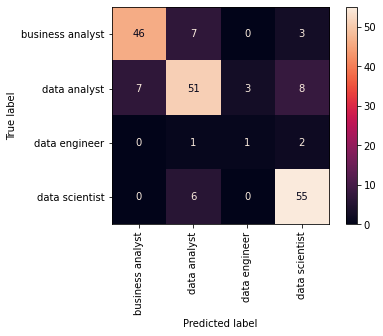

In [204]:
plot_confusion_matrix(clf_nb, X_test, y_test, values_format='d', xticks_rotation='vertical', cmap='rocket');

This result looks disturbingly good
- Have I overfitted?
- Have I made an error?  Is the model classifying the jobs that well? (80%)

Should now do some side-by-side analysis of the results

# Data exploration

Try a few things
- Wordcloud
- nltk freqdistoud

## Wordcloud
Create a wordcloud for all job description text.

In [ ]:
# Read the whole text.
text = ' '.join(df['description'].tolist())

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=100, width=800, height=800).generate(text)
WordCloud()
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Create a wordcloud for all jobtitle text only

Analyst, 

In [ ]:
# Read the job title only]
text = ' '.join(df['title'].tolist())

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
wordcloud = WordCloud(max_font_size=100, width=800, height=800).generate(text)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


# Feature Engineering

Added many boolean features to indicate presence of some manual keywords in the data. 

In [ ]:
df.columns

# Using NLP to auto extract text-based features
I will now try to use NLTK's functions to extract more automatic text based features

For each job description
- Function-ise some data cleaning code
  - Make sure stop words are removed
  - Lower case
  - Remove punctuation
- Tokenise the sentences
- Tokenise the words in each sentence
- Lemmatise the words
- For each sentence, construct bigrams and trigrams
- Filter down to the X most frequent occurrances, for each job title. (Job titles to classify should just be the ones in the `query_title` column
- Combine these with the manual keyword columns, and assemble into a feature vector
- Finish by expressing this as an Sklearn pipeline

## Information extraction
The objective here should be to try to extract info on skills.  So we can build a classifier that looks at the advert description text, and based on the list of skills identified

## Tokenisation

In [ ]:
def ie_preprocess(document):
    # Use list comprehension to 
#     sentences = [p for p in text.split('\n') if p]
    paras = []
    for para in document.split('\n'):
        paras.extend(nltk.sent_tokenize(para))
#         paras.append(para)
    sentences = paras    
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
#     sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences
    
# Start from scratch
text = df.description.iloc[0]

a = ie_preprocess(text)
# pp = pprint.PrettyPrinter()
# pp.pprint(a)
a


In [ ]:
grammar = "NP: {<DT>?<JJ>*<NN>}"

cp = nltk.RegexpParser(grammar)
result = cp.parse(a)

# Create a custom SKlearn transformer based on NLTK

https://bbengfort.github.io/2016/05/text-classification-nltk-sckit-learn/ used as inspiration for the NLTK transformer structure to interface with sklearn pipelines

In [ ]:
import time

def timeit(func):
    """
    Simple timing decorator
    """
    def wrapper(*args, **kwargs):
        start  = time.time()
        result = func(*args, **kwargs)
        delta  = time.time() - start
        return result, delta
    return wrapper

In [ ]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin


class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report as clsr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as tts

@timeit
def build_and_evaluate(X, y,
    classifier=SGDClassifier, outpath=None, verbose=True):

    @timeit
    def build(classifier, X, y=None):
        """
        Inner build function that builds a single model.
        """
        if isinstance(classifier, type):
            classifier = classifier()

        model = Pipeline([
            ('preprocessor', NLTKPreprocessor()),
            ('vectorizer', TfidfVectorizer(
                tokenizer=identity, preprocessor=None, lowercase=False
            )),
            ('classifier', classifier),
        ])

        model.fit(X, y)
        return model

    # Label encode the targets
    labels = LabelEncoder()
    y = labels.fit_transform(y)

    # Begin evaluation
    if verbose: print("Building for evaluation")
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    model, secs = build(classifier, X_train, y_train)

    if verbose:
        print("Evaluation model fit in {:0.3f} seconds".format(secs))
        print("Classification Report:\n")

    y_pred = model.predict(X_test)
    print(clsr(y_test, y_pred, target_names=labels.classes_))

    if verbose:
        print("Building complete model and saving ...")
    model, secs = build(classifier, X, y)
    model.labels_ = labels

    if verbose:
        print("Complete model fit in {:0.3f} seconds".format(secs))

    if outpath:
        with open(outpath, 'wb') as f:
            pickle.dump(model, f)

        print("Model written out to {}".format(outpath))

    return model

In [ ]:
from nltk.corpus import movie_reviews as reviews

X = [reviews.raw(fileid) for fileid in reviews.fileids()]
y = [reviews.categories(fileid)[0] for fileid in reviews.fileids()]

model = build_and_evaluate(X,y, outpath=None)